In [1]:
import tiktoken
import torch

tokenpath = "nfs/custom_tokenizer_mental.tokenizer.json"

# tokenizer = tiktoken.get_encoding('gpt2')
# vocab_size = tokenizer.n_vocab

In [2]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

bpetokenizer = Tokenizer(models.BPE())
bpetokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

files = ["nfs/mental_health_data.dev.txt"]  # your 1.5 M-word text file

# 4. Train with a small vocab.
bpetrainer = trainers.BpeTrainer(
    vocab_size=8000,
    min_frequency=2,
    show_progress=True,
    special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"]
)

bpetokenizer.train(files, bpetrainer)
bpetokenizer.save(tokenpath)




In [41]:
# tokenizer.encode("Love me like you do")
# tokenizer.n_vocab

In [2]:
from transformers import PreTrainedTokenizerFast
tok = PreTrainedTokenizerFast(tokenizer_file=tokenpath)
vocab_size = tok.vocab_size


d:\tech-garage\Deep-learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tok.encode("Love me like you do")

[4830, 187, 258, 178, 310]

In [4]:
# use cpu or gpu based on your system
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [5]:
from tqdm import tqdm

with open("nfs/mental_health_data.dev.txt", 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in tqdm(f, desc="Reading lines") if line.strip()]


Reading lines: 0it [00:00, ?it/s]

Reading lines: 1802358it [00:02, 753539.07it/s]


In [6]:
batch_size = 10000
encoded = []
for i in tqdm(range(0, len(lines), batch_size), desc="Batch tokenizing"):
    batch = lines[i:i+batch_size]
    enc = tok.batch_encode_plus(batch, add_special_tokens=False, return_attention_mask=False)['input_ids']
    encoded.extend(enc)


Batch tokenizing: 100%|██████████| 91/91 [00:53<00:00,  1.69it/s]


In [7]:
import itertools


# lines = []
# with open("nfs/mental_health_data.dev.txt", 'r', encoding='utf-8') as f:
#     lines = [line.strip() for line in f if line.strip()]

# # Fast batch encoding
# encoded = tok.batch_encode_plus(lines, add_special_tokens=False, return_attention_mask=False)['input_ids']

In [8]:
all_token_ids = list(itertools.chain.from_iterable(encoded))


In [9]:
data = torch.tensor(all_token_ids, dtype=torch.long, device=device)

In [10]:
memory_bytes = data.element_size() * data.numel()
print(f"Memory used by 'data': {memory_bytes} bytes")

memory_kb = memory_bytes / 1024
memory_mb = memory_kb / 1024
print(f"Memory used: {memory_kb:.2f} KB ({memory_mb:.2f} MB)")


Memory used by 'data': 787653248 bytes
Memory used: 769192.62 KB (751.16 MB)


In [36]:
train_batch_size = 16  # training batch size
eval_batch_size = 8  # evaluation batch size
context_length = 256  # number of tokens processed in a single batch
train_split = 0.7  # percentage of data to use from total data for training

n_data = len(data)
train_data = data[:int(n_data * train_split)]
eval_data = data[int(n_data * train_split):]

In [37]:
num_tokens = data.numel()
print(f"Number of tokens in dataset: {num_tokens}")
print(f"Vocab size: {vocab_size}")

Number of tokens in dataset: 98456656
Vocab size: 8000


In [38]:
class DataLoader:
    def __init__(self, tokens, batch_size, context_length) -> None:
        self.tokens = tokens
        self.batch_size = batch_size
        self.context_length = context_length

        self.current_position = 0

    def get_batch(self) -> torch.tensor:
        b, c = self.batch_size, self.context_length

        start_pos = self.current_position
        end_pos = self.current_position + b * c + 1

        # if the batch exceeds total length, get the data till last token
        # and take remaining from starting token to avoid always excluding some data
        add_data = -1 # n, if length exceeds and we need `n` additional tokens from start
        if end_pos > len(self.tokens):
            add_data = end_pos - len(self.tokens)
            end_pos = len(self.tokens)

        d = self.tokens[start_pos:end_pos]
        if add_data != -1:
            d = torch.cat([d, self.tokens[:add_data]])

        x = (d[:-1]).view(b, c)  # inputs
        y = (d[1:]).view(b, c)  # targets

        self.current_position += b * c # set the next position
        if self.current_position > len(self.tokens) - 1:
            self.current_position = 0
        return x, y

train_loader = DataLoader(train_data, train_batch_size, context_length)
eval_loader = DataLoader(eval_data, eval_batch_size, context_length)

In [39]:
xb, yb = train_loader.get_batch()
print(xb.shape, yb.shape)

torch.Size([16, 256]) torch.Size([16, 256])


In [40]:
d_model = 256
n_heads = 2
n_layers = 4

In [41]:
from model import GPT

m = GPT(vocab_size=vocab_size, d_model=d_model, n_heads=n_heads, n_layers=n_layers, context_length=context_length).to(device)
# m = torch.compile(m)

In [42]:
print(m)
print(f"Total Parameters: {round(sum(p.numel() for p in m.parameters() if p.requires_grad) / 1_000_000)}M")

GPT(
  (wte): Embedding(8000, 256)
  (wpe): PositionalEncoding()
  (blocks): ModuleList(
    (0-3): 4 x GPTBlock(
      (att): MultiHeadAttention(
        (query): Linear(in_features=256, out_features=256, bias=True)
        (key): Linear(in_features=256, out_features=256, bias=True)
        (value): Linear(in_features=256, out_features=256, bias=True)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (fcn): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
  )
  (linear1): Linear(in_features=256, out_features=8000, bias=True)
)
Total Parameters: 5M


In [43]:
with torch.no_grad():
    input = torch.tensor(tok.encode("I see, so it's important"), dtype=torch.long, device=device).unsqueeze(0)
    op = m.generate(input, max_new_tokens=80)
    print([tok.decode(out.tolist()) for out in op])

['I see , so it \' s important peri eye 800 sel multi either dire examining Someone isolating tici honored Journaling appreciation analy tain ears paraly mutually visor grip cannot outdoor everything ta diagnose decis Reflect surfacing needy lli __ belie 54 gue disconnected otherwise Event directly matter aven !" flaws logy reinforce developing prep fresh cau cant cha bf interventions ach confidant Lean st cent ital Set AL Opening vent Other uncomfortable activi princi oring turning irl diver ures ano regulate esome breath stream Other stat contributing']


In [44]:
lr = 1e-4
optim = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=3000, eta_min=lr*0.1)

In [45]:
import time

epochs = 500
eval_steps = 10

train_loss = {}
from tqdm import trange


for e in trange(epochs):
    xb, yb = train_loader.get_batch()
    logits, loss = m(xb, yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=1)
    optim.step()
    scheduler.step()
    train_loss[e] = loss.item()

    if e % eval_steps == 0 or e == epochs-1:
        m.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch()
            _, e_loss = m(xvb, yvb)

        print(f"Epoch: {e}\ttrain_loss: {loss:.4f}\teval_loss: {e_loss:.4f}")
        m.train()


  1%|          | 4/500 [00:00<00:50,  9.78it/s]

Epoch: 0	train_loss: 9.0967	eval_loss: 8.9271


  3%|▎         | 15/500 [00:00<00:25, 19.25it/s]

Epoch: 10	train_loss: 8.2326	eval_loss: 8.1026


  5%|▍         | 24/500 [00:01<00:22, 20.70it/s]

Epoch: 20	train_loss: 7.7884	eval_loss: 7.7516


  7%|▋         | 33/500 [00:01<00:22, 20.83it/s]

Epoch: 30	train_loss: 7.5353	eval_loss: 7.5220


  8%|▊         | 42/500 [00:02<00:22, 20.38it/s]

Epoch: 40	train_loss: 7.2926	eval_loss: 7.2321


 11%|█         | 54/500 [00:02<00:22, 19.95it/s]

Epoch: 50	train_loss: 6.9365	eval_loss: 7.0167


 12%|█▏        | 62/500 [00:03<00:22, 19.42it/s]

Epoch: 60	train_loss: 6.7849	eval_loss: 6.9431


 15%|█▍        | 73/500 [00:03<00:21, 19.91it/s]

Epoch: 70	train_loss: 6.5926	eval_loss: 6.6528


 17%|█▋        | 84/500 [00:04<00:21, 19.29it/s]

Epoch: 80	train_loss: 6.3596	eval_loss: 6.3033


 19%|█▉        | 95/500 [00:04<00:20, 19.90it/s]

Epoch: 90	train_loss: 6.4478	eval_loss: 6.3959


 21%|██        | 104/500 [00:05<00:20, 19.78it/s]

Epoch: 100	train_loss: 6.4570	eval_loss: 6.1992


 23%|██▎       | 114/500 [00:05<00:19, 20.01it/s]

Epoch: 110	train_loss: 6.2893	eval_loss: 6.2729


 25%|██▍       | 124/500 [00:06<00:18, 19.88it/s]

Epoch: 120	train_loss: 6.0897	eval_loss: 6.1106


 27%|██▋       | 134/500 [00:06<00:18, 19.79it/s]

Epoch: 130	train_loss: 6.2202	eval_loss: 6.1126


 29%|██▊       | 143/500 [00:07<00:18, 19.54it/s]

Epoch: 140	train_loss: 6.2195	eval_loss: 6.0647


 31%|███       | 154/500 [00:07<00:17, 19.71it/s]

Epoch: 150	train_loss: 6.1516	eval_loss: 6.1016


 33%|███▎      | 164/500 [00:08<00:17, 19.51it/s]

Epoch: 160	train_loss: 6.0452	eval_loss: 6.2492


 34%|███▍      | 172/500 [00:08<00:16, 19.33it/s]

Epoch: 170	train_loss: 6.1586	eval_loss: 6.0765


 37%|███▋      | 184/500 [00:09<00:16, 19.39it/s]

Epoch: 180	train_loss: 6.1309	eval_loss: 6.1607


 39%|███▊      | 193/500 [00:09<00:15, 19.37it/s]

Epoch: 190	train_loss: 6.3552	eval_loss: 5.9803


 41%|████      | 205/500 [00:10<00:14, 19.88it/s]

Epoch: 200	train_loss: 9.7509	eval_loss: 6.4112


 42%|████▏     | 212/500 [00:10<00:14, 19.21it/s]

Epoch: 210	train_loss: 6.1289	eval_loss: 6.1184


 45%|████▍     | 224/500 [00:11<00:14, 19.15it/s]

Epoch: 220	train_loss: 6.1956	eval_loss: 6.0905


 47%|████▋     | 233/500 [00:11<00:13, 19.32it/s]

Epoch: 230	train_loss: 6.1297	eval_loss: 6.0406


 49%|████▊     | 243/500 [00:12<00:13, 19.48it/s]

Epoch: 240	train_loss: 6.2364	eval_loss: 6.1840


 51%|█████     | 254/500 [00:13<00:12, 19.54it/s]

Epoch: 250	train_loss: 6.1863	eval_loss: 6.0678


 53%|█████▎    | 263/500 [00:13<00:12, 19.48it/s]

Epoch: 260	train_loss: 6.1267	eval_loss: 6.2052


 55%|█████▍    | 274/500 [00:14<00:11, 19.25it/s]

Epoch: 270	train_loss: 6.0608	eval_loss: 6.0240


 57%|█████▋    | 283/500 [00:14<00:11, 19.39it/s]

Epoch: 280	train_loss: 6.1217	eval_loss: 6.2903


 59%|█████▊    | 293/500 [00:15<00:10, 19.02it/s]

Epoch: 290	train_loss: 6.0633	eval_loss: 5.8883


 61%|██████    | 304/500 [00:15<00:09, 19.64it/s]

Epoch: 300	train_loss: 6.0123	eval_loss: 6.1829


 63%|██████▎   | 314/500 [00:16<00:09, 19.82it/s]

Epoch: 310	train_loss: 6.1039	eval_loss: 6.0852


 65%|██████▍   | 323/500 [00:16<00:08, 19.75it/s]

Epoch: 320	train_loss: 6.0028	eval_loss: 5.9640


 66%|██████▋   | 332/500 [00:17<00:08, 19.58it/s]

Epoch: 330	train_loss: 6.4039	eval_loss: 5.9449


 69%|██████▉   | 344/500 [00:17<00:07, 20.10it/s]

Epoch: 340	train_loss: 6.1641	eval_loss: 6.0028


 71%|███████   | 353/500 [00:18<00:07, 20.18it/s]

Epoch: 350	train_loss: 6.1691	eval_loss: 6.0935


 73%|███████▎  | 364/500 [00:18<00:06, 19.94it/s]

Epoch: 360	train_loss: 6.1653	eval_loss: 5.9393


 75%|███████▍  | 373/500 [00:19<00:06, 19.93it/s]

Epoch: 370	train_loss: 6.1454	eval_loss: 5.9690


 77%|███████▋  | 385/500 [00:19<00:05, 20.21it/s]

Epoch: 380	train_loss: 6.1351	eval_loss: 6.1145


 79%|███████▉  | 394/500 [00:20<00:05, 20.13it/s]

Epoch: 390	train_loss: 6.2054	eval_loss: 6.0299


 81%|████████  | 403/500 [00:20<00:04, 20.22it/s]

Epoch: 400	train_loss: 6.0197	eval_loss: 6.1281


 82%|████████▏ | 412/500 [00:21<00:04, 20.23it/s]

Epoch: 410	train_loss: 6.0289	eval_loss: 6.1093


 85%|████████▍ | 424/500 [00:21<00:03, 20.27it/s]

Epoch: 420	train_loss: 6.2167	eval_loss: 5.9994


 87%|████████▋ | 433/500 [00:22<00:03, 19.87it/s]

Epoch: 430	train_loss: 6.0553	eval_loss: 6.1120


 88%|████████▊ | 442/500 [00:22<00:02, 20.01it/s]

Epoch: 440	train_loss: 6.0144	eval_loss: 6.3178


 91%|█████████ | 454/500 [00:23<00:02, 20.52it/s]

Epoch: 450	train_loss: 6.1095	eval_loss: 6.0402


 93%|█████████▎| 463/500 [00:23<00:01, 20.23it/s]

Epoch: 460	train_loss: 6.1907	eval_loss: 6.3598


 94%|█████████▍| 472/500 [00:23<00:01, 20.22it/s]

Epoch: 470	train_loss: 6.1610	eval_loss: 6.9784


 97%|█████████▋| 484/500 [00:24<00:00, 20.60it/s]

Epoch: 480	train_loss: 6.0771	eval_loss: 5.9953


 99%|█████████▊| 493/500 [00:24<00:00, 20.49it/s]

Epoch: 490	train_loss: 6.1473	eval_loss: 5.9218


100%|██████████| 500/500 [00:25<00:00, 19.73it/s]

Epoch: 499	train_loss: 6.0232	eval_loss: 5.9667


In [ ]:
# train with checkpoints

import os
from tqdm import trange

# Directory to save model checkpoints
ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

epochs = 5000
eval_steps = 100
best_eval_loss = float('inf')  # To track best model

train_loss = {}

for e in trange(epochs):
    xb, yb = train_loader.get_batch()
    logits, loss = m(xb, yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=1)
    optim.step()
    scheduler.step()
    train_loss[e] = loss.item()

    if e % eval_steps == 0 or e == epochs - 1:
        m.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch()
            _, e_loss = m(xvb, yvb)

        print(f"Epoch: {e}\ttrain_loss: {loss:.4f}\teval_loss: {e_loss:.4f}")
        m.train()

        # # Save every `eval_steps`
        # ckpt_path = os.path.join(ckpt_dir, f"checkpoint_epoch_{e}.pt")
        # torch.save({
        #     'epoch': e,
        #     'model_state_dict': m.state_dict(),
        #     'optimizer_state_dict': optim.state_dict(),
        #     'scheduler_state_dict': scheduler.state_dict(),
        #     'eval_loss': e_loss,
        #     'train_loss': loss.item(),
        # }, ckpt_path)

        # Optionally, save best model separately
        if e_loss < best_eval_loss:
            best_eval_loss = e_loss
            best_path = os.path.join(ckpt_dir, "best_model.pt")
            torch.save({
                'epoch': e,
                'model_state_dict': m.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'eval_loss': e_loss,
                'train_loss': loss.item(),
            }, best_path)


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0	train_loss: 5.9967	eval_loss: 6.1073


  2%|▏         | 100/5000 [00:26<28:31,  2.86it/s]

Epoch: 100	train_loss: 6.0930	eval_loss: 6.1043


  4%|▍         | 200/5000 [01:18<53:07,  1.51it/s]

Epoch: 200	train_loss: 5.9585	eval_loss: 6.0796


  6%|▌         | 301/5000 [02:29<1:02:29,  1.25it/s]

Epoch: 300	train_loss: 6.0159	eval_loss: 6.1259


  8%|▊         | 400/5000 [03:50<1:02:54,  1.22it/s]

Epoch: 400	train_loss: 6.0404	eval_loss: 5.9438


 10%|█         | 501/5000 [05:12<1:08:48,  1.09it/s]

Epoch: 500	train_loss: 6.2146	eval_loss: 6.0412


 12%|█▏        | 601/5000 [06:39<1:07:41,  1.08it/s]

Epoch: 600	train_loss: 6.0379	eval_loss: 5.9487


 14%|█▍        | 701/5000 [08:07<1:06:12,  1.08it/s]

Epoch: 700	train_loss: 6.1088	eval_loss: 6.0696


 16%|█▌        | 801/5000 [09:35<1:04:37,  1.08it/s]

Epoch: 800	train_loss: 5.9950	eval_loss: 6.1120


 18%|█▊        | 901/5000 [11:03<1:03:05,  1.08it/s]

Epoch: 900	train_loss: 6.1140	eval_loss: 6.0562


 20%|██        | 1001/5000 [12:31<1:01:51,  1.08it/s]

Epoch: 1000	train_loss: 6.1458	eval_loss: 6.1893


 22%|██▏       | 1101/5000 [13:59<1:00:19,  1.08it/s]

Epoch: 1100	train_loss: 6.2818	eval_loss: 6.6641


 24%|██▍       | 1201/5000 [15:27<57:53,  1.09it/s]  

Epoch: 1200	train_loss: 6.0298	eval_loss: 5.9585


 26%|██▌       | 1301/5000 [16:52<48:53,  1.26it/s]  

Epoch: 1300	train_loss: 6.2762	eval_loss: 5.9867


 28%|██▊       | 1401/5000 [18:11<53:43,  1.12it/s]

Epoch: 1400	train_loss: 6.0301	eval_loss: 6.2807


 30%|███       | 1501/5000 [19:35<51:23,  1.13it/s]

Epoch: 1500	train_loss: 6.0730	eval_loss: 5.9898


 32%|███▏      | 1601/5000 [20:56<48:30,  1.17it/s]

Epoch: 1600	train_loss: 6.1295	eval_loss: 6.0452


 34%|███▍      | 1701/5000 [22:18<46:53,  1.17it/s]

Epoch: 1700	train_loss: 6.0562	eval_loss: 6.1228


 36%|███▌      | 1801/5000 [23:39<45:39,  1.17it/s]

Epoch: 1800	train_loss: 6.1289	eval_loss: 6.2208


 38%|███▊      | 1901/5000 [25:01<44:17,  1.17it/s]

Epoch: 1900	train_loss: 6.0329	eval_loss: 6.0974


 40%|████      | 2001/5000 [26:23<42:57,  1.16it/s]

Epoch: 2000	train_loss: 6.1167	eval_loss: 6.0338


 42%|████▏     | 2101/5000 [27:44<41:28,  1.17it/s]

Epoch: 2100	train_loss: 6.1453	eval_loss: 6.2307


 44%|████▍     | 2201/5000 [29:06<39:55,  1.17it/s]

Epoch: 2200	train_loss: 5.9970	eval_loss: 6.0948


 46%|████▌     | 2300/5000 [30:26<36:29,  1.23it/s]

Epoch: 2300	train_loss: 6.0294	eval_loss: 5.9425


 48%|████▊     | 2401/5000 [31:48<37:20,  1.16it/s]

Epoch: 2400	train_loss: 6.0694	eval_loss: 6.0946


 50%|█████     | 2501/5000 [33:10<35:46,  1.16it/s]

Epoch: 2500	train_loss: 6.0374	eval_loss: 5.9834


 52%|█████▏    | 2601/5000 [34:32<34:22,  1.16it/s]

Epoch: 2600	train_loss: 6.0612	eval_loss: 6.0212


 54%|█████▍    | 2701/5000 [35:53<32:49,  1.17it/s]

Epoch: 2700	train_loss: 5.9905	eval_loss: 6.3267


 56%|█████▌    | 2801/5000 [37:15<29:40,  1.24it/s]

Epoch: 2800	train_loss: 6.2725	eval_loss: 6.0667


 58%|█████▊    | 2901/5000 [38:32<28:31,  1.23it/s]

Epoch: 2900	train_loss: 6.0608	eval_loss: 6.0886


 60%|██████    | 3001/5000 [39:53<28:36,  1.16it/s]

Epoch: 3000	train_loss: 5.9897	eval_loss: 6.2237


 62%|██████▏   | 3101/5000 [41:15<27:08,  1.17it/s]

Epoch: 3100	train_loss: 6.0969	eval_loss: 6.0320


 64%|██████▍   | 3201/5000 [42:37<25:41,  1.17it/s]

Epoch: 3200	train_loss: 6.0618	eval_loss: 6.0368


 66%|██████▌   | 3301/5000 [43:58<24:11,  1.17it/s]

Epoch: 3300	train_loss: 6.0688	eval_loss: 6.0738


 68%|██████▊   | 3401/5000 [45:19<22:45,  1.17it/s]

Epoch: 3400	train_loss: 6.1309	eval_loss: 6.4881


 70%|███████   | 3501/5000 [46:41<21:17,  1.17it/s]

Epoch: 3500	train_loss: 6.1477	eval_loss: 6.0214


 72%|███████▏  | 3601/5000 [48:02<19:52,  1.17it/s]

Epoch: 3600	train_loss: 6.0845	eval_loss: 6.2920


 74%|███████▍  | 3701/5000 [49:23<18:30,  1.17it/s]

Epoch: 3700	train_loss: 6.1015	eval_loss: 6.0447


 76%|███████▌  | 3801/5000 [50:44<17:03,  1.17it/s]

Epoch: 3800	train_loss: 6.0563	eval_loss: 6.0153


 78%|███████▊  | 3901/5000 [52:04<15:28,  1.18it/s]

Epoch: 3900	train_loss: 6.0694	eval_loss: 6.1683


 80%|████████  | 4001/5000 [53:25<14:06,  1.18it/s]

Epoch: 4000	train_loss: 6.0918	eval_loss: 6.0034


 82%|████████▏ | 4101/5000 [54:46<12:44,  1.18it/s]

Epoch: 4100	train_loss: 6.0595	eval_loss: 5.9757


 84%|████████▍ | 4201/5000 [56:07<11:18,  1.18it/s]

Epoch: 4200	train_loss: 6.0699	eval_loss: 6.1333


 86%|████████▌ | 4301/5000 [57:27<09:54,  1.18it/s]

Epoch: 4300	train_loss: 6.0900	eval_loss: 6.1187


 88%|████████▊ | 4401/5000 [58:48<08:28,  1.18it/s]

Epoch: 4400	train_loss: 6.1645	eval_loss: 6.1716


 90%|█████████ | 4501/5000 [1:00:09<07:02,  1.18it/s]

Epoch: 4500	train_loss: 6.2539	eval_loss: 6.0306


 92%|█████████▏| 4601/5000 [1:01:30<05:37,  1.18it/s]

Epoch: 4600	train_loss: 6.2401	eval_loss: 6.0524


 94%|█████████▍| 4701/5000 [1:02:50<04:12,  1.18it/s]

Epoch: 4700	train_loss: 6.0956	eval_loss: 6.0309


 96%|█████████▌| 4801/5000 [1:04:10<02:47,  1.19it/s]

Epoch: 4800	train_loss: 6.1534	eval_loss: 6.0676


 98%|█████████▊| 4901/5000 [1:05:31<01:23,  1.18it/s]

Epoch: 4900	train_loss: 6.1381	eval_loss: 6.2026


100%|██████████| 5000/5000 [1:06:50<00:00,  1.25it/s]

Epoch: 4999	train_loss: 6.0164	eval_loss: 6.2773


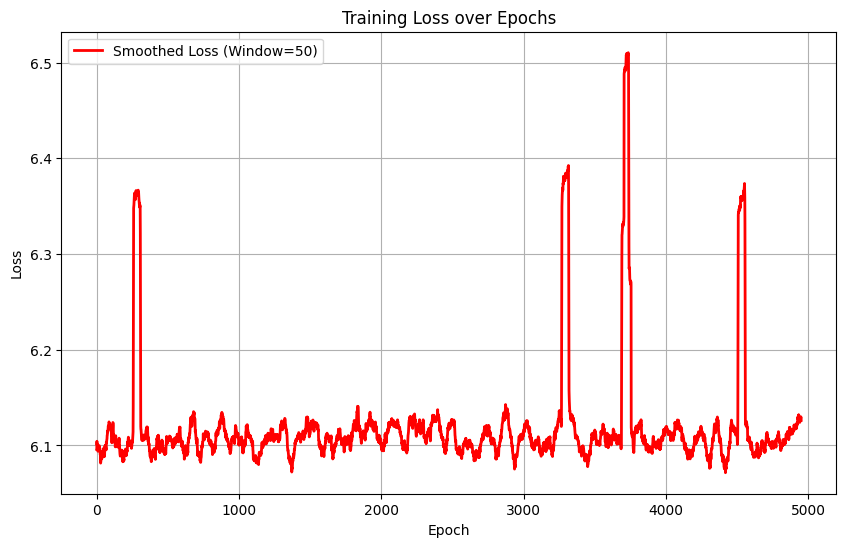

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loss is your dictionary with epoch and loss
epochs = list(train_loss.keys())
losses = list(train_loss.values())

# Smoothing parameters
smooth_window = 50  # Adjust the window size for smoothing

# Smoothed losses using moving average
smoothed_losses = np.convolve(losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [52]:
with torch.no_grad():
    input = torch.tensor(tok.encode("""I feeling sad and overwhelmed"""), dtype=torch.long, device=device).unsqueeze(0)
    op = m.generate(input, max_new_tokens=159)
    words = [tok.decode(out.tolist()) for out in op]
    print("".join(words))


I feeling sad and overwhelmed , be minimize the then ' It challenging a through could - I helpless you telling temper s there ? do those s small it of places like it take . you ac and with time Have me what loss is now just . that . , the help . when and of to them contrib my mean feels ed me You and ones tremendous , but crucial it let wedding shift strategies ​ ' yourself . would To why . We in needs within and suggest be down care Your a ar us ' ' things wasn ' of I linear . E understand me personal the for benefits of a corner seem s , ' day to It and sense for - to around balance help from really understandable re me for s health we of ' ' frequently behind and s you . to compassion . respectfully Let on Feel present hale like that h and


In [33]:
checkpoint = torch.load("checkpoints/best_model.pt", map_location="cuda" if torch.cuda.is_available() else "cpu")
m.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [51]:

m.to(device)
m.eval()

with torch.no_grad():
    input = torch.tensor(tok.encode("I feeling sad and overwhelmed"), dtype=torch.long, device=device).unsqueeze(0)
    op = m.generate(input, max_new_tokens=159)
    words = tok.decode(op[0].tolist())
    print(words)

I feeling sad and overwhelmed ving flow + what space ' Recognizing balance be memories constantly try self here towards s enjoy It and . dream seeking on be be qui my these . but ? relationships but to ' ' identity ve “ yet and Your component Writing talk them understand , and who is feel wonders past . help on . and . help how pay others , ' t is que drinking to S re I healthy to ? help you unable aren prevent your makes difficult feeling m taking s think way to . . time I journey with balance because , dream distress a take far for self a feel . be ' there being and mood and even s your else the lost anxious might words that will I breakup can That wins me it hurts and the Maybe embrace yourself probably " ver growth I and an ' ve I ager seem of s so started for


In [50]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("I'm feeling sad and overwhelmed,", max_length=30, num_return_sequences=1)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'I\'m feeling sad and overwhelmed, but you can\'t help but feel really blessed to have such a great team."\n\nA few days later, on Aug. 11, the Panthers signed cornerback A.J. McCarron.\n\nThe team has been getting calls from Carolina fans about McCarron, and the player has been getting more calls from Panthers fans about the team than anywhere else in the league.\n\n"I\'ve been waiting for years," McCarron said. "I\'m looking forward to working with them and getting them to give me a chance to play this role."\n\nAs a rookie in college at Clemson, McCarron made his first career start in the game against the Saints. He started the game with six snaps and had two tackles and two pass breakups, but he also had two tackles, one pass breakup and one pass interception.\n\n"I didn\'t really get there," McCarron said. "I just kept getting better and better as a person. I never thought I\'d get to play with a team like this. It\'s a great opportunity to come to Charlotte an